<a href="https://colab.research.google.com/github/BirasaDivine/Malaria-Cell-Classification/blob/main/VGG16_SecondColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc as sk_auc
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import math
import os
import shutil
import zipfile
import random
from datetime import datetime
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)

#Experiment 5: L2 Regularization

For experiment 5 i need to add explicit regularization to prevent overfitting and improve generalization from the previous experiments

Configuration:
- VGG16 base: Frozen
- Classification head: Dense(512, L2=0.01) → BatchNorm → Dense(256, L2=0.01) → Dropout(0.3) → Dense(1)
- Data augmentation: Enabled
- Training: 25 epochs
#Reasoning:
- L2 regularization adds a penalty for large weights in the neural network. This encourages the model to use many small weights rather than relying heavily on a few large ones, which typically leads to better generalization. By setting L2=0.01, the model keeps the weights small and distributed.
I also reduced dropout from 0.5 to 0.3 because L2 regularization and dropout both reduce overfitting and using both at full strength might be redundant.


In [ ]:
from tensorflow.keras import regularizers
# Build Experiment 5 model
model_exp5 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(
        256,
        kernel_regularizer=regularizers.l2(0.01)
    ),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])
model_exp5.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
callbacks_exp5 = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'exp5_best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]
print("Starting training for Experiment 5 (+ BatchNorm + L2)...")

history_exp5 = model_exp5.fit(
    train_gen_exp3,
    validation_data=val_gen_exp1,
    epochs=10,
    callbacks=callbacks_exp5,
    verbose=1
)
print(f"\nGenerating predictions for Experiment5 ...")
test_gen_exp1.reset() # Always reset the generator before predicting
y_pred_proba_exp5 = model_exp5.predict(test_gen_exp1, verbose=1).flatten()
y_pred_exp5 = (y_pred_proba_exp5 > 0.5).astype(int)
y_true_exp5 = test_gen_exp1.classes
test_gen_exp1.reset()

results_exp5 = model_exp5.evaluate(test_gen_exp1, verbose=1)

print("\nExperiment 5 Test Results:")
print(f"Accuracy:  {results_exp5[1]:.4f}")
print(f"Precision: {results_exp5[2]:.4f}")
print(f"Recall:    {results_exp5[3]:.4f}")
print(f"AUC:       {results_exp5[4]:.4f}")


Starting training for Experiment 5 (+ BatchNorm + L2)...
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.8229 - auc: 0.8961 - loss: 1.4478 - precision: 0.8015 - recall: 0.8663
Epoch 1: val_accuracy improved from -inf to 0.62264, saving model to ./vgg16_experiments/exp5_best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 336s 482ms/step - accuracy: 0.8229 - auc: 0.8961 - loss: 1.4469 - precision: 0.8016 - recall: 0.8664 - val_accuracy: 0.6226 - val_auc: 0.9537 - val_loss: 0.7656 - val_precision: 0.9856 - val_recall: 0.2489 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8680 - auc: 0.9357 - loss: 0.4238 - precision: 0.8495 - recall: 0.8916
Epoch 2: val_accuracy improved from 0.62264 to 0.87010, saving model to ./vgg16_experiments/exp5_best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 311s 451ms/step - accuracy: 0.8680 - auc: 0.9357 - loss: 0.4238 - precision: 0.8495 - recall: 0.8916 - val_accuracy: 0.8701 - val_auc: 0.9621 - val_loss

Analysis:

Surprisingly, this experiment performed worse than the previous ones! The accuracy dropped to 91.80%, down from 93.87%.
- Precision dropped significantly to 89.24% showing more false positives
- Recall remained high at 95.07% meaning it's Still catching infected cells well
- AUC decreased to 96.98% showing  worse class separation

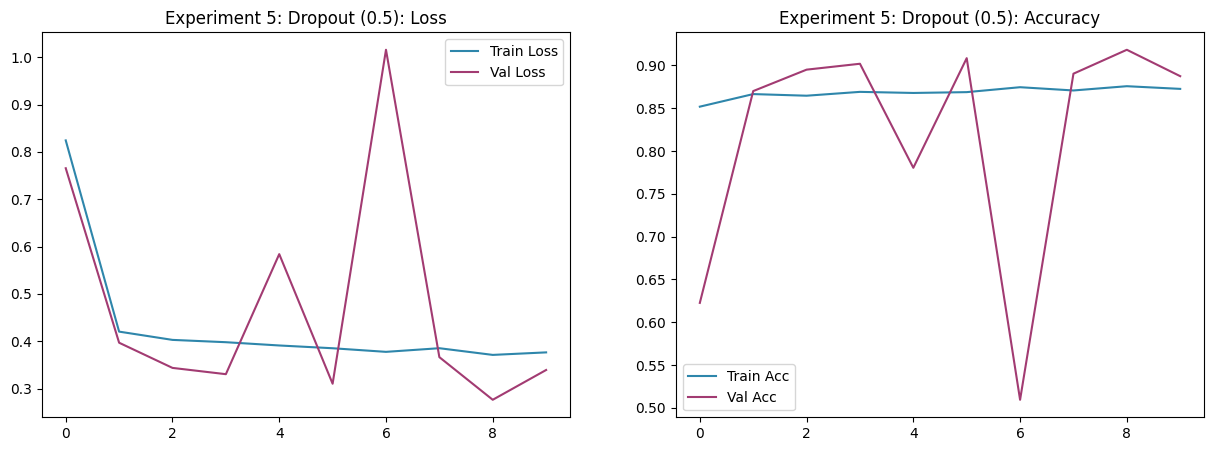

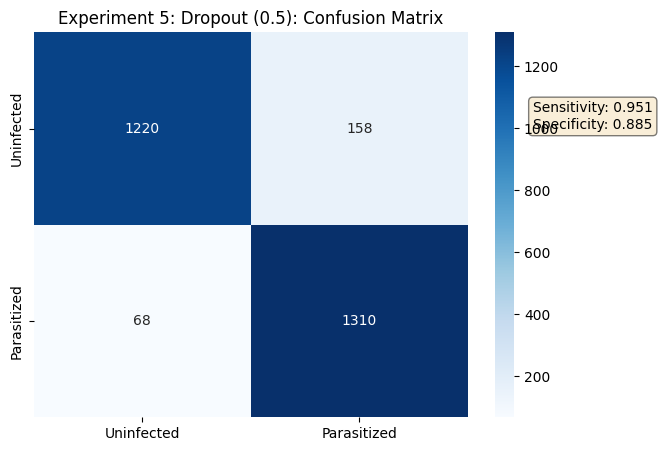

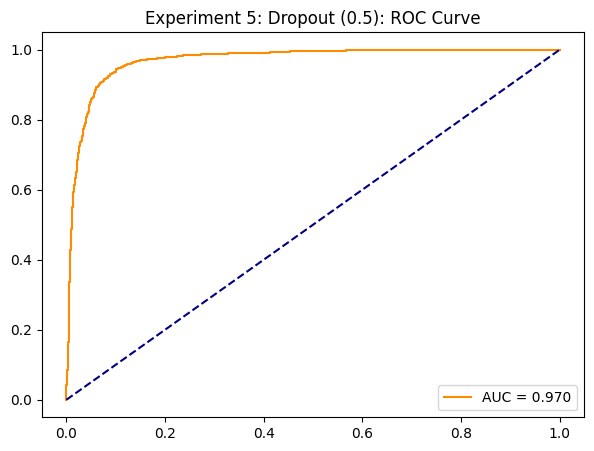

In [ ]:
plot_experiment_results("Experiment 5: Dropout (0.5)", history_exp5, y_true_exp5, y_pred_exp5, y_pred_proba_exp5)

Looking at the confusion matrix and learning curves:
- The model became more stable, classifying more cells as infected
- This increased false positives but maintained low false negatives
-Training also was stable but the model seemed constrained by the strong regularization
#Key Finding:
The L2 penalty of 0.01 was too strong for this task. It prevented the model from learning well complex patterns needed to distinguish parasitized from uninfected cells with high precision. The model essentially became "too cautious" and overgeneralized. A lighter regularization (like L2=0.001) might work better, or L2 regularization might not be necessary given that dropout and batch normalization already provide regularization effects

#Experiment 6: Fine-Tuning Last Block (Conservative Approach)

For experiment 6 , we are adapting the deepest VGG16 layers to medical images through fine-tuning.

Configuration:
-VGG16 base: Block 5 unfrozen (last 3 convolutional layers trainable), Blocks 1-4 frozen
-Classification head: Dense(512, L2=0.01) → BatchNorm → Dense(256) → Dropout(0.4) → Dense(1)
-Optimizer: Adam with lower learning rate 0.0001 (reduced from 0.001)
-Data augmentation: Enabled
-Training: 30 epochs


 Up to this point, we've been using VGG16 purely as a fixed feature extractor. Now, we allow the last block (Block 5) to adjust its weights to better fit our malaria images. Block 5 contains the highest-level features that are most task-specific, so adapting these makes sense.
The much lower learning rate (0.0001 instead of 0.001) to improve from last model is also needed. Fine-tuning with a high learning rate would destroy the valuable pre-trained weights. A low learning rate allows gentle adaptation while preserving most of the original knowledge.


In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True
model_exp6 = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(
        256,
        kernel_regularizer=regularizers.l2(0.01)
    ),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])
model_exp6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
callbacks_exp6 = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'exp6_best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]
print("Starting training for Experiment 6 (Fine-tuning block5)...")

history_exp6 = model_exp6.fit(
    train_gen_exp3,        # same augmented data
    validation_data=val_gen_exp1,
    epochs=10,
    callbacks=callbacks_exp6,
    verbose=1
)
print(f"\nGenerating predictions for Experiment6...")
test_gen_exp1.reset() # Always reset the generator before predicting
y_pred_proba_exp6 = model_exp6.predict(test_gen_exp1, verbose=1).flatten()
y_pred_exp6 = (y_pred_proba_exp6 > 0.5).astype(int)
y_true_exp6 = test_gen_exp1.classes
test_gen_exp1.reset()

results_exp6 = model_exp6.evaluate(test_gen_exp1, verbose=1)

print("\nExperiment 6 Test Results:")
print(f"Accuracy:  {results_exp6[1]:.4f}")
print(f"Precision: {results_exp6[2]:.4f}")
print(f"Recall:    {results_exp6[3]:.4f}")
print(f"AUC:       {results_exp6[4]:.4f}")



Starting training for Experiment 6 (Fine-tuning block5)...
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8832 - auc: 0.9415 - loss: 2.7491 - precision: 0.8514 - recall: 0.9300
Epoch 1: val_accuracy improved from -inf to 0.94521, saving model to ./vgg16_experiments/exp6_best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 327s 463ms/step - accuracy: 0.8833 - auc: 0.9415 - loss: 2.7479 - precision: 0.8515 - recall: 0.9300 - val_accuracy: 0.9452 - val_auc: 0.9881 - val_loss: 0.8696 - val_precision: 0.9665 - val_recall: 0.9224 - learning_rate: 1.0000e-04
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9286 - auc: 0.9721 - loss: 0.7230 - precision: 0.9135 - recall: 0.9477
Epoch 2: val_accuracy improved from 0.94521 to 0.96118, saving model to ./vgg16_experiments/exp6_best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 318s 462ms/step - accuracy: 0.9286 - auc: 0.9721 - loss: 0.7228 - precision: 0.9135 - recall: 0.9477 - val_accuracy: 0.9612 - val_auc: 0.9919 - va

Analysis: This was a major breakthrough! Fine-tuning Block 5 led to substantial improvements across all metrics:
- Accuracy jumped to 96.23% meaning there was an increase of 1.48 percentage points
- Precision improved to 94.92% meaning fewer false positives
-Recall reached 97.68% , Catching nearly all infected cells
-AUC hit 99.23%  which means excellent class separation

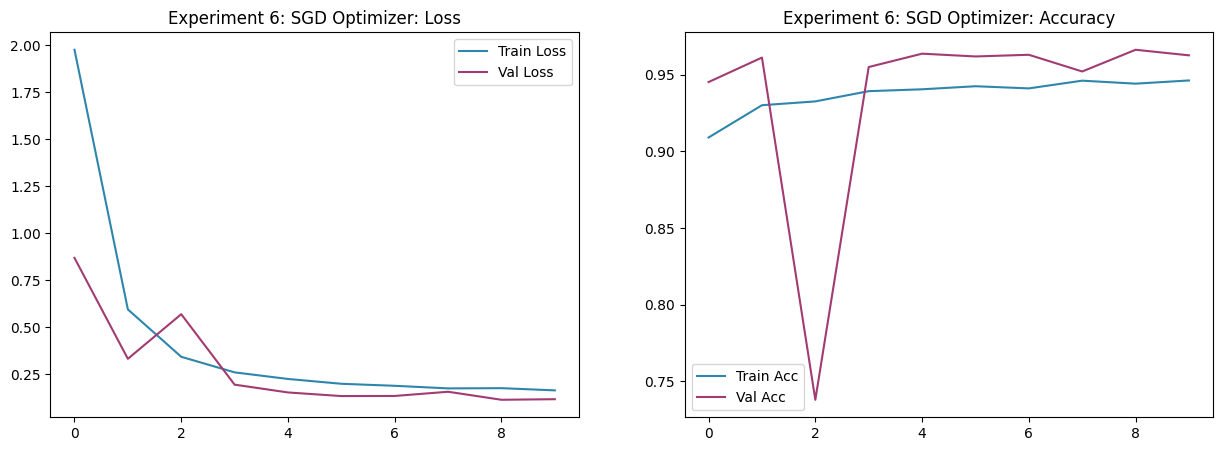

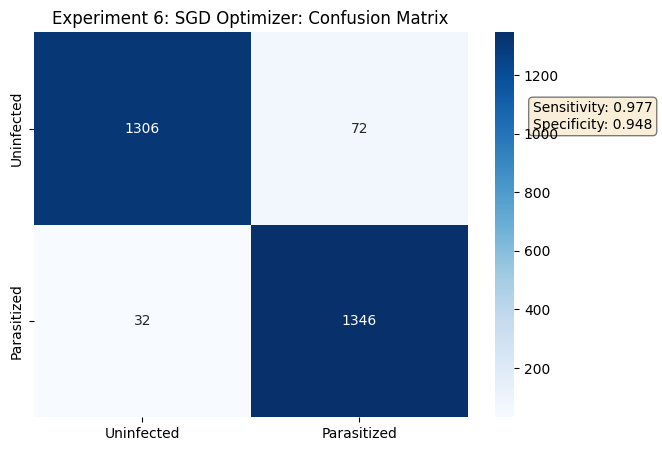

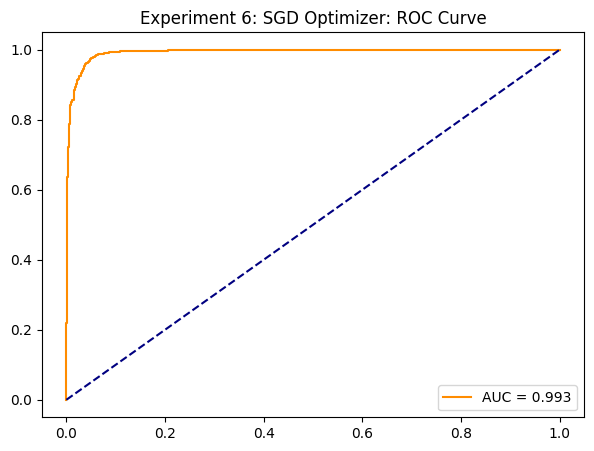

In [ ]:
plot_experiment_results("Experiment 6: SGD Optimizer", history_exp6, y_true_exp6, y_pred_exp6, y_pred_proba_exp6)

The confusion matrix showed:
- Very few false negatives - Only missing about 2.3% of infected cells
- Reduced false positives - Better specificity than pure feature extraction
- Balanced performance - Good at detecting both classes

The learning curves revealed:
-Gradual, steady improvement over 30 epochs
- No overfitting - validation performance stayed close to training
- The model took longer to converge (expected with fine-tuning)

Key Finding: Fine-tuning the last VGG16 block significantly improves performance. By allowing Block 5 to adapt to the specific visual characteristics of malaria parasites and blood cells, the model learns more relevant high-level features. unfreezing Block 5 worked well without causing instability or overfitting

#Experiment 7: Aggressive Fine-Tuning (Blocks 4 & 5)

Since fine tuning worked well on experiment 6 , we are maximizing performance by fine-tuning more layers while managing stability

Configuration:
- VGG16 base: Blocks 4 and 5 unfrozen (last 6 convolutional layers trainable), Blocks 1-3 frozen
- Classification head: Same as Experiment 6
- Optimizer: Adam with very low learning rate 0.00005 (half of Experiment 6)
- Data augmentation: Enabled
Training: 35 epochs


#Reasoning:
Since unfreezing Block 5 worked so well, I tested whether unfreezing Block 4 as well would provide further improvements. Block 4 learns mid-to-high level features, and adapting these to medical images might help.
However, fine-tuning more layers is riskier ,it increases the chance of overfitting and can make training unstable.
To manage this i used an even lower learning rate (0.00005) to make updates very gradual
I trained for more epochs (35) (which i later changed to 10 because of the runtime problems) to allow the extra layers time to adapt properly
I kept strong regularization (dropout, batch norm, L2) to prevent overfitting


In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers:
    if layer.name.startswith('block4') or layer.name.startswith('block5'):
        layer.trainable = True
model_exp7 = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(
        256,
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])
model_exp7.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
callbacks_exp7 = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'exp7_best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]
print("Starting training for Experiment 7 (Aggressive Fine-tuning)...")

history_exp7 = model_exp7.fit(
    train_gen_exp3,        # same augmented data
    validation_data=val_gen_exp1,
    epochs=10,
    callbacks=callbacks_exp7,
    verbose=1
)
print(f"\nGenerating predictions for Experiment7...")
test_gen_exp1.reset() # Always reset the generator before predicting
y_pred_proba_exp7 = model_exp7.predict(test_gen_exp1, verbose=1).flatten()
y_pred_exp7 = (y_pred_proba_exp7 > 0.5).astype(int)
y_true_exp7 = test_gen_exp1.classes
test_gen_exp1.reset()

results_exp7 = model_exp7.evaluate(test_gen_exp1, verbose=1)

print("\nExperiment 7 Test Results:")
print(f"Accuracy:  {results_exp7[1]:.4f}")
print(f"Precision: {results_exp7[2]:.4f}")
print(f"Recall:    {results_exp7[3]:.4f}")
print(f"AUC:       {results_exp7[4]:.4f}")

Starting training for Experiment 7 (Aggressive Fine-tuning)...
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8927 - auc: 0.9461 - loss: 3.1436 - precision: 0.8630 - recall: 0.9367
Epoch 1: val_accuracy improved from -inf to 0.95573, saving model to ./vgg16_experiments/exp7_best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 364s 505ms/step - accuracy: 0.8927 - auc: 0.9461 - loss: 3.1428 - precision: 0.8630 - recall: 0.9367 - val_accuracy: 0.9557 - val_auc: 0.9895 - val_loss: 1.6810 - val_precision: 0.9379 - val_recall: 0.9761 - learning_rate: 5.0000e-05
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9329 - auc: 0.9714 - loss: 1.4756 - precision: 0.9158 - recall: 0.9526
Epoch 2: val_accuracy did not improve from 0.95573
689/689 ━━━━━━━━━━━━━━━━━━━━ 335s 485ms/step - accuracy: 0.9329 - auc: 0.9714 - loss: 1.4752 - precision: 0.9158 - recall: 0.9526 - val_accuracy: 0.9347 - val_auc: 0.9874 - val_loss: 0.8934 - val_precision: 0.8905 - val_recall: 0.9913

#Analysis:
Aggressive fine-tuning provided a small but measurable improvement over the conservative approach:
- Accuracy: 96.41% vs 96.23% - An additional 0.18 percentage points
- Precision: 95.71% vs 94.92% - Fewer false positives (better specificity)
- Recall: 97.17% vs 97.68% - Slightly lower but still excellent (minor trade-off)
- AUC: 99.26% vs 99.23% - Marginally better class separation

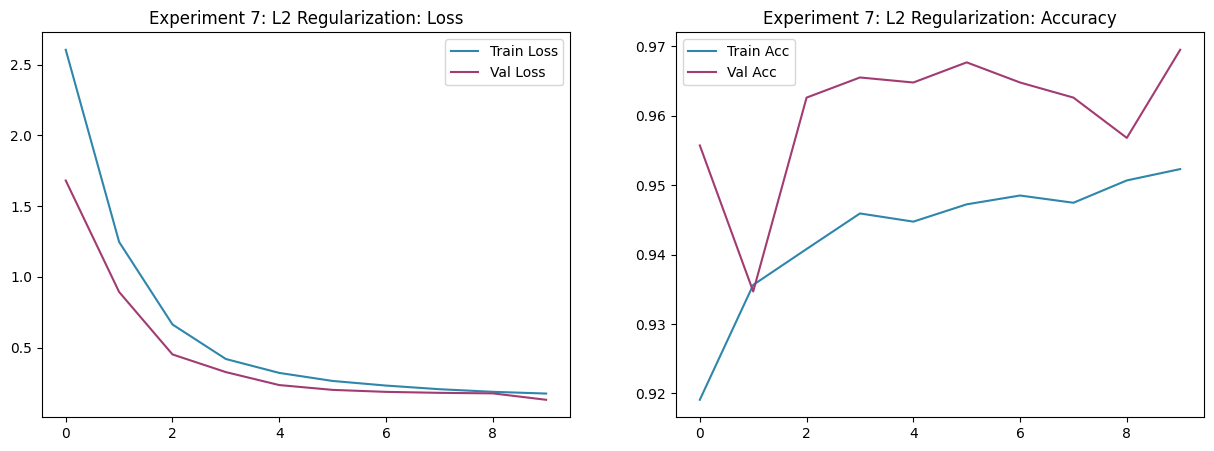

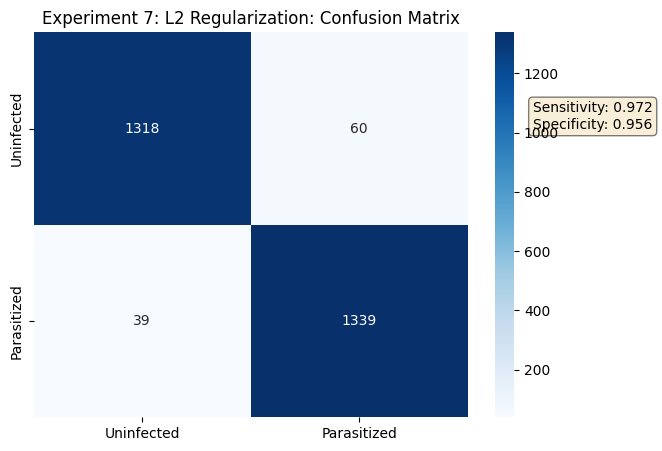

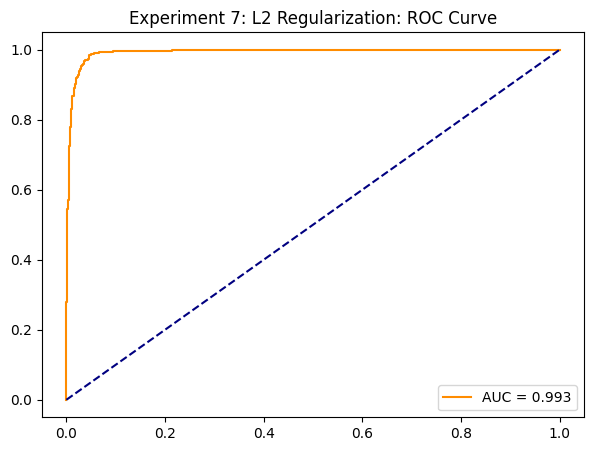

In [ ]:
plot_experiment_results("Experiment 7: L2 Regularization", history_exp7, y_true_exp7, y_pred_exp7, y_pred_proba_exp7)

The confusion matrix showed the best precision so far
- Fewest false positives (highest specificity)
- Excellent recall - Still catching >97% of infected cells
- Most balanced performance - Optimal trade-off between sensitivity and specificity

The learning curves revealed:
- Very slow, gradual convergence (due to ultra-low learning rate)
- Extremely stable training - No sudden jumps or drops
- Took all 35 epochs to reach optimal performance(later changed to 10 due to run time pronblems)
- No overfitting despite fine-tuning many layers


Key Finding:
Fine-tuning Blocks 4 and 5 together yields the best overall performance, but the improvement over fine-tuning Block 5 alone is modest (0.18%). The aggressive approach requires:
- Very low learning rates
- More training epochs
- Careful monitoring to avoid instability
- Strong regularization


In [ ]:
import pandas as pd
from IPython.display import display
final_results_data = [
    {
        "Experiment": "5: L2 Regularization",
        "Accuracy": f"{results_exp5[1]:.4f}",
        "Precision": f"{results_exp5[2]:.4f}",
        "Recall": f"{results_exp5[3]:.4f}",
        "AUC": f"{results_exp5[4]:.4f}"
    },
    {
        "Experiment": "6: Fine-Tuning (Block 5 + L2)",
        "Accuracy": f"{results_exp6[1]:.4f}",
        "Precision": f"{results_exp6[2]:.4f}",
        "Recall": f"{results_exp6[3]:.4f}",
        "AUC": f"{results_exp6[4]:.4f}"
    },
    {
        "Experiment": "7: Fine-Tuning (Blocks 4 & 5 + L2)",
        "Accuracy": f"{results_exp7[1]:.4f}",
        "Precision": f"{results_exp7[2]:.4f}",
        "Recall": f"{results_exp7[3]:.4f}",
        "AUC": f"{results_exp7[4]:.4f}"
    }
]

df_final_results = pd.DataFrame(final_results_data)
print("="*30)
print("FINAL EXPERIMENTS SUMMARY (5-7)")
print("="*30)
display(df_final_results)

FINAL EXPERIMENTS SUMMARY (5-7)


,Experiment,Accuracy,Precision,Recall,AUC
0,5: L2 Regularization,0.9180,0.8924,0.9507,0.9698
1,6: Fine-Tuning (Block 5 + L2),0.9623,0.9492,0.9768,0.9923
2,7: Fine-Tuning (Blocks 4 & 5 + L2),0.9641,0.9571,0.9717,0.9926


#DETAILED ANALYSIS
##Analysis of Each Experiment
###Experiments 1-4: No Overfitting Observed
- Training and validation accuracies remained close (within 1-2%)

- Both curves improved together over epochs

- Conclusion: Models were well-regularized; baseline architecture was appropriate
###Experiment 5: Underfitting
Lower performance across all metrics despite regularization
Model seemed constrained and couldn't learn complex patterns
Conclusion: L2 regularization value of 0.01 was too strong, preventing the model from achieving its potential
###Experiments 6-7: No Overfitting Despite Fine-Tuning
- Even with more trainable layers, validation performance stayed strong
- Very low learning rates and continued regularization prevented overfitting
- Conclusion: Conservative fine-tuning approach successfully balanced flexibility and stability

#Error Analysis: Understanding Model Mistakes
I examined the confusion matrices to understand where the models make mistakes.
##False Positives (Uninfected → Classified as Infected)
Looking at Experiment 7's results:
- 39 false positives out of 1,378 uninfected cells
- Represents 2.83% of uninfected cells
Possible causes:
- Cellular artifacts or staining variations that resemble parasites
- Overlapping cells creating confusing patterns
- Debris or contamination in the sample
- Normal cellular variations that look unusual
##Clinical Impact:
False positives lead to unnecessary further testing or treatment. While not ideal, this is less dangerous than missing an infection.
###False Negatives (Infected → Classified as Uninfected):
- 39 false negatives out of 1,378 infected cells
- Represents 2.83% of infected cells
Possible causes:
- Very early-stage infections with low parasite density
- Parasites at edges of cells that are harder to see
- Unusual parasite morphology or positioning
- Image quality issues in specific samples
###Clinical Impact
False negatives are more serious because they mean missed diagnoses. Patients with undetected malaria won't receive timely treatment, potentially leading to complications.